# Summary

This work tries to implement the forward-forward algorithm by Geoffrey Hinton [(link to paper)](https://www.cs.toronto.edu/~hinton/FFA13.pdf).

I used digits 0 to 4 as positive data, and 5 - 9 as negative data. This is different from the paper's setting.

The basic supervised and unsupervised results use the following settings:

1. `units = 100` (number of units in each hidden layer)
2. `batch_size = 128`
3. data shuffling enabled
4. train all layers in every epoch
5. epochs = 200

Their validation accuracies are:

1. unsupervised-wise FF: 
    - 96.64% @ basic setting
    - 98.44% @ changing to `units = 500` and `batch_size = 512`
    - 99.06% @ changing to `units = 2000` and `batch_size = 512`
2. supervised-wise FF:
    - 76.41% @ basic setting
    - 95.76% @ changing to `units = 500` and `batch_size = 512`
    - 97.42% @ changing to `units = 2000` and `batch_size = 512`

A similar setting with backprop can reach over 99% easily within 20 epochs.

For other results, refer to the table below. b1, b2, b3, b4 are final binary cross entropy. softmax and goodness are best accuracy reachable in 200 epochs.

|No. | FF mode      | changes                        |     b1 |     b2 |     b3 |     b4 |   best_softmax |   best_goodness_duped |
|:---|-------------:|-------------------------------:|-------:|-------:|-------:|-------:|---------------:|----------------------:|
|A1  | unsupervised |                                | 0.02   | 0.0446 | 0.129  | 0.1452 | [[**0.9664**]] |              N/A      |
|A2  | unsupervised | units = 500                    | 0.0108 | 0.0098 | 0.0189 | 0.0544 |         0.9840 |              N/A      |
|A3  | unsupervised | batch_size = 512               | 0.0251 | 0.0602 | 0.1151 | 0.1361 |         0.9709 |              N/A      |
|A4  | unsupervised | disabled data shuffling        | 0.0174 | 0.0464 | 0.1488 | 0.1487 |         0.9605 |              N/A      |
|A5  | unsupervised | batch_size = 32                | 0.0291 | 0.0626 | 0.0817 | 0.1208 |         0.9664 |              N/A      |
|A6  | unsupervised | train one layer at a time      | 0.02   | 0.0094 | 0.0418 | 0.0282 |         0.9461 |              N/A      |
|B7  | supervised   |                                | 0.01   | 0.0233 | 0.0933 | 0.1073 |       N/A      |        [[**0.7641**]] |
|B8  | supervised   | units = 500                    | 0.0066 | 0.0042 | 0.0121 | 0.0331 |       N/A      |                0.9256 |
|B9  | supervised   | batch_size = 512               | 0.017  | 0.0457 | 0.1006 | 0.1121 |       N/A      |                0.801  |
|B10 | supervised   | disabled data shuffling        | 0.0094 | 0.0213 | 0.1052 | 0.0965 |       N/A      |                0.7771 |
|B11 | supervised   | batch_size = 32                | 0.0166 | 0.0385 | 0.0552 | 0.1274 |       N/A      |                0.7145 |
|B12 | supervised   | train one layer at a time      | 0.01   | 0.0016 | 0.0145 | 0.0129 |       N/A      |                0.7078 |
|    |              |                                |        |        |        |        |                |                       |
|C13 | unsupervised | units = 500, batch_size = 512  | 0.0155 | 0.0304 | 0.0569 | 0.0769 | [[**0.9844**]] |              N/A      |
|C14 | supervised   | units = 500, batch_size = 512  | 0.0096 | 0.0204 | 0.0428 | 0.0550 |       N/A      |        [[**0.9576**]] |
|    |              |                                |        |        |        |        |                |                       |
|D15 | unsupervised | units = 2000, batch_size = 512 | 0.0108 | 0.0142 | 0.0225 | 0.0370 | [[**0.9906**]] |              N/A      |
|D16 | supervised   | units = 2000, batch_size = 512 | 0.0065 | 0.0075 | 0.0133 | 0.0240 |       N/A      |        [[**0.9742**]] |

Some other observations:

1. Extra rounds of softmax training for unsupervised-FF can squeeze a bit more accuracy out. 
2. Training all layers in every epoch is better than completing one layer after another. (test 1 vs. test 6)
3. 1st and 2nd hidden layers tend to have smooth exponential dropping loss, but 3rd and 4th looks linear-piecewise.
4. Test 12 seems to indicate that over-trained hidden layer is bad for never-trained subsequent hidden layer.
5. It seems that we can overtrain a FF-based layer, or we can have a overtrain problem.

# Imports

In [1]:
import sys
sys.path.append("../../ffobjects/")

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from data import create_mnist_datasets
from utils import set_seed, plot_training_curves
from trainmgr import TrainMgr
from ffobjects import FFPreNorm, FFDense, FFSoftmax, FFOverlay, FFGoodness

# CONFIGURATION
NUM_CLASS = 5 # Only digits 0 to 4 are positive samples
IMG_SHAPE = (28, 28, )

# Helper functions for tests

1. `create_layers_and_train_seq`: create layers and a `train_seq` function. The latter uses the former to define how the layers are connected at training.
2. `train_layers`: execute the training process.

In [2]:
def create_layers_and_train_seq(units, is_supervised_ff, seed):
    set_seed(seed=seed)
    
    embedding = tf.reshape(
    tf.one_hot(tf.range(NUM_CLASS), tf.reduce_prod(IMG_SHAPE)), 
    (NUM_CLASS, *IMG_SHAPE))
    
    layers = dict(
        # Utilities
        input = tf.keras.layers.InputLayer(name='input'),
        concat = tf.keras.layers.Concatenate(name='concat'),
        flatten = tf.keras.layers.Flatten(name='flatten'),
        preNorm = FFPreNorm(name='preNorm'),
        overlay = FFOverlay(embedding, name='overlay'),

        # FF layers
        b1 = FFDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b1'),
        b2 = FFDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b2'),
        b3 = FFDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b3'),
        b4 = FFDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b4'),

        # Classifiers
        softmax = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax'),
        goodness = FFGoodness(name=f'goodness'),
    )

    def train_seq(X, y, y_ff):
        x = layers['input'](X)
        if is_supervised_ff:
            x = layers['overlay'].ff_do_task(x, y)
        x = layers['flatten'](x)
        b1a = layers['b1'].ff_do_task(x, y_ff)
        b1n = layers['preNorm'](b1a)
        b2a = layers['b2'].ff_do_task(b1n, y_ff)
        b2n = layers['preNorm'](b2a)
        b3a = layers['b3'].ff_do_task(b2n, y_ff)
        b3n = layers['preNorm'](b3a)
        b4a = layers['b4'].ff_do_task(b3n, y_ff)
        b4n = layers['preNorm'](b4a)
        if is_supervised_ff:
            goodness_x = layers['concat']([b2a, b3a, b4a])
            y_pred = layers['goodness'].ff_do_task(goodness_x, y)
        else:
            softmax_x = layers['concat']([b2n, b3n, b4n])
            y_pred = layers['softmax'].ff_do_task(softmax_x, y)
        return y_pred
    
    return layers, train_seq

def train_layers(
    units, is_supervised_ff, 
    batch_size, data_shuffle_seed, 
    trainable_layers_list, show_metrics_max,
):
    '''
    Refer to the example in the next cell for explanation of arguments.
    '''
    layers, train_seq = create_layers_and_train_seq(
        units=units, 
        seed=300, 
        is_supervised_ff=is_supervised_ff)
    
    set_seed(seed=300)
    dataset = create_mnist_datasets(
        seed=data_shuffle_seed, 
        batch_size=batch_size, 
        include_duped=is_supervised_ff)
    train_mgr = TrainMgr(layers, train_seq).ff_train(
        dataset, 
        trainable_layers_list, 
        show_metrics_max=show_metrics_max)
    plot_training_curves(train_mgr)
    return train_mgr

# A. Unsupervised-wise FF tests 1 - 6

## 1. original setting

50/50 [==============================] - 47s 928ms/step - softmax: 0.9676 - best_softmax: 0.9678


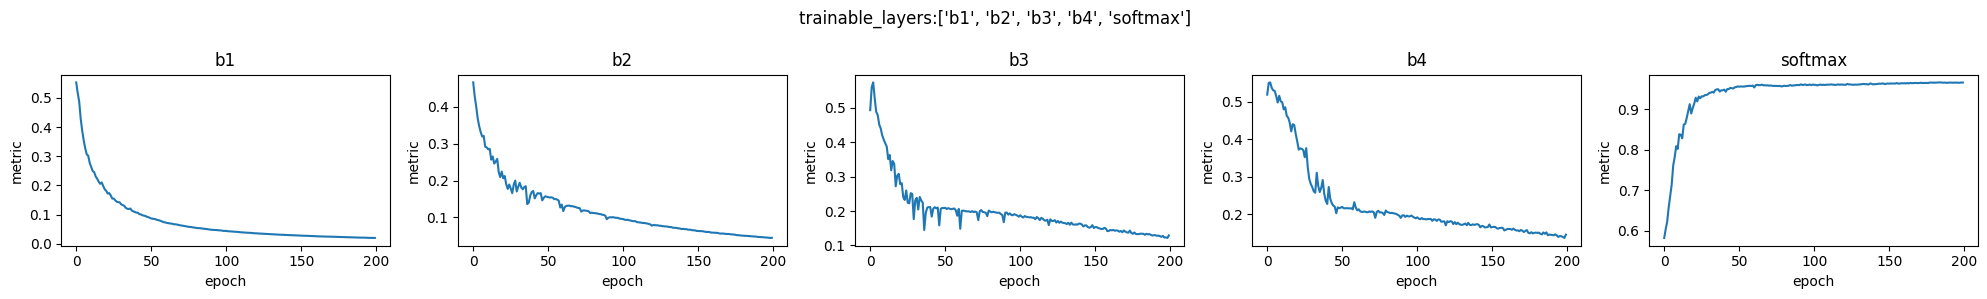

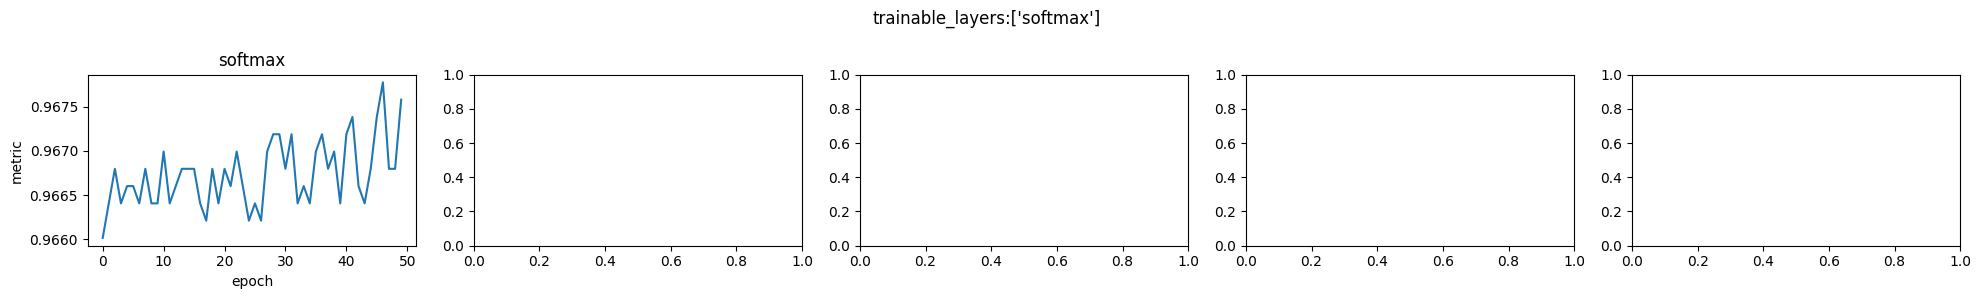

In [3]:
train_mgr = train_layers(
    units = 100,              # number of units in each hidden layer
    is_supervised_ff = False, # Whether this is supervised-FF or unsupervised-FF
    batch_size = 128,         # batch size
    data_shuffle_seed = 10,   # Set this to None for no shuffling, otherwise will reshuffle every epoch
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200], # 200 epochs of training listed layers
        [['softmax'], 50],                          #  50 epochs of training listed layers
    ],
    show_metrics_max = ['softmax'], # show maximum softmax so far
)

## 2. change `units = 500`

50/50 [==============================] - 136s 3s/step - softmax: 0.9842 - best_softmax: 0.9846


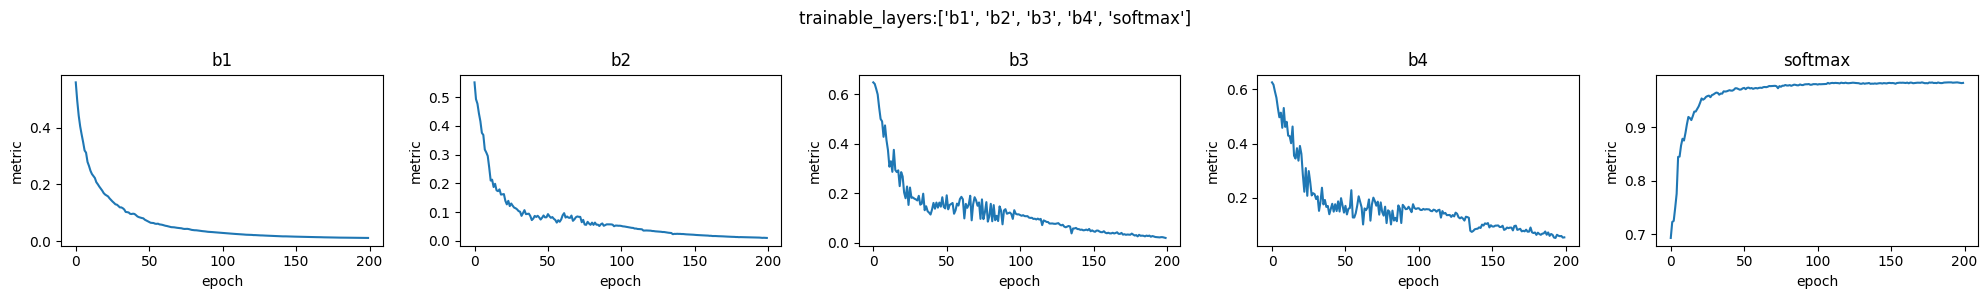

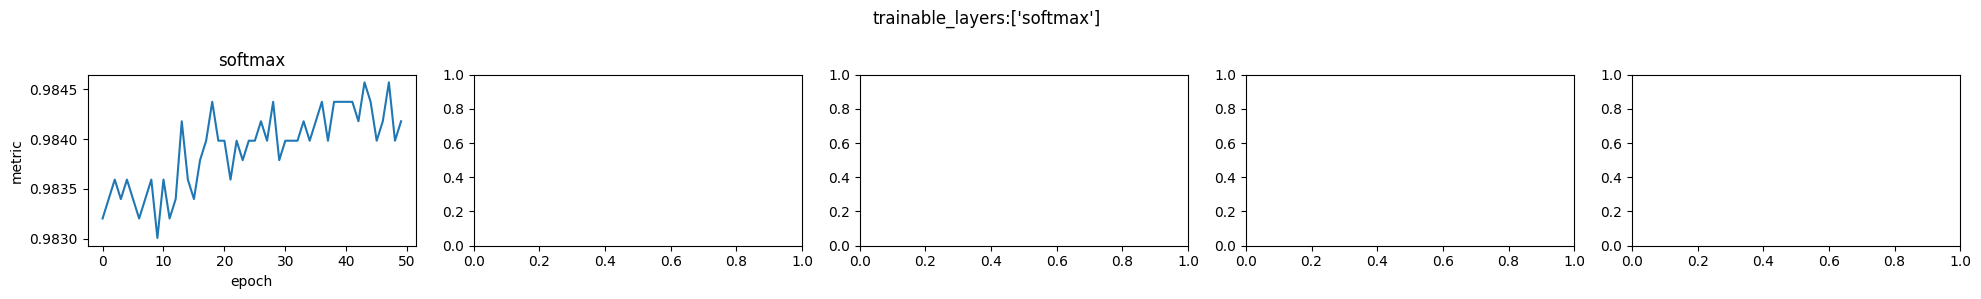

In [4]:
train_mgr = train_layers(
    units = 500, #Changed
    is_supervised_ff = False,
    batch_size = 128,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200],
        [['softmax'], 50], 
    ],
    show_metrics_max = ['softmax'],
)

## 3. change `batch_size=512`

50/50 [==============================] - 35s 682ms/step - softmax: 0.9725 - best_softmax: 0.9730


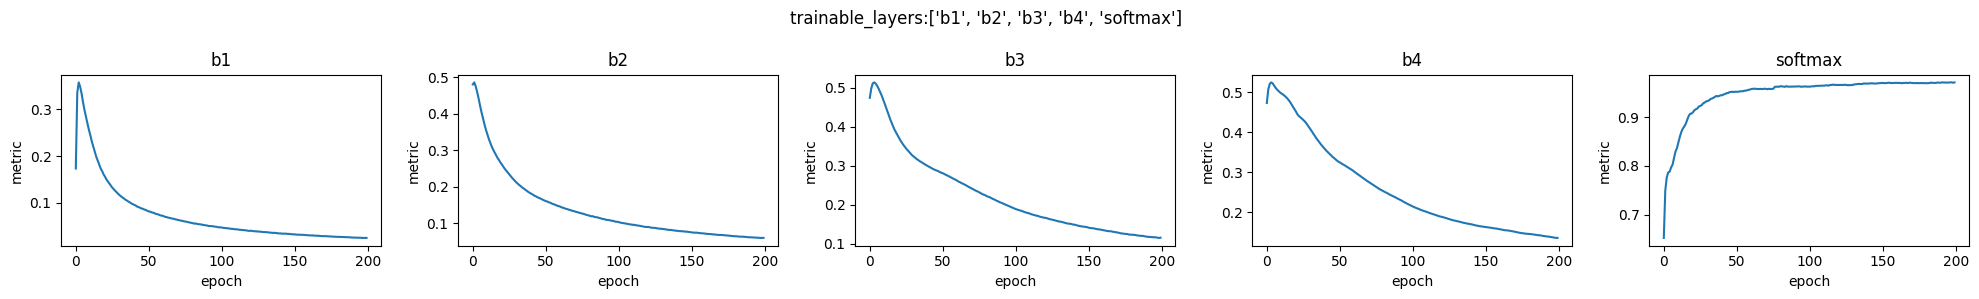

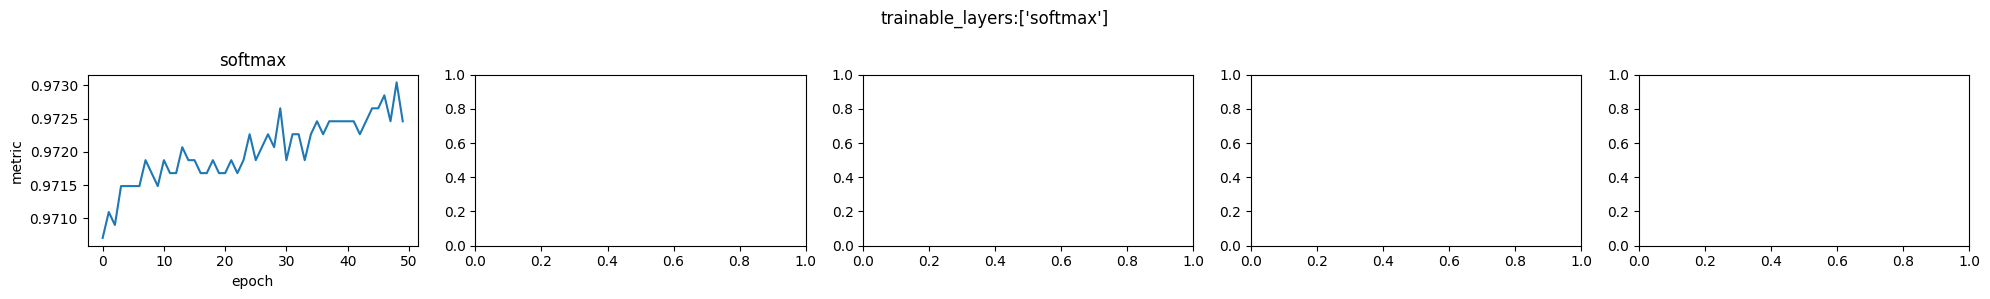

In [5]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = False,
    batch_size = 512, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200],
        [['softmax'], 50], 
    ],
    show_metrics_max = ['softmax'],
)

## 4. change `batch_size = 32`

50/50 [==============================] - 71s 1s/step - softmax: 0.9668 - best_softmax: 0.9672


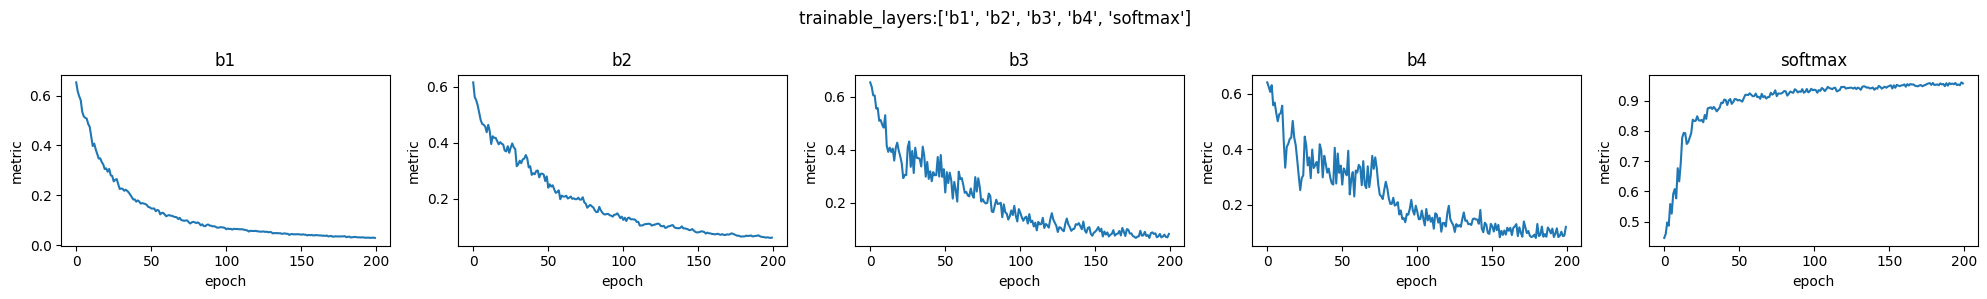

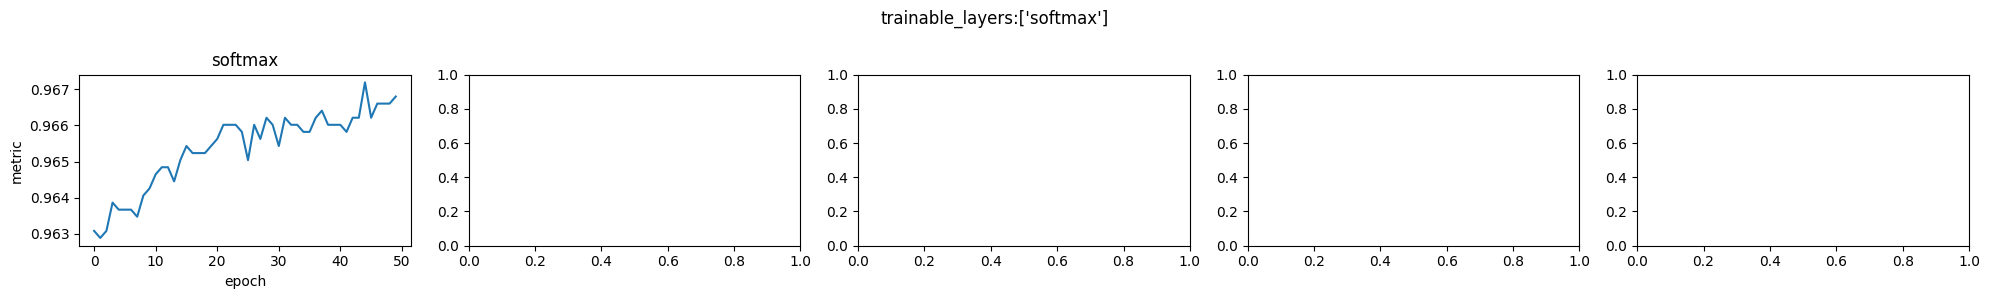

In [6]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = False,
    batch_size = 32, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200],
        [['softmax'], 50], 
    ],
    show_metrics_max = ['softmax'],
)

## 5. disable data shuffling

50/50 [==============================] - 38s 751ms/step - softmax: 0.9672 - best_softmax: 0.9672


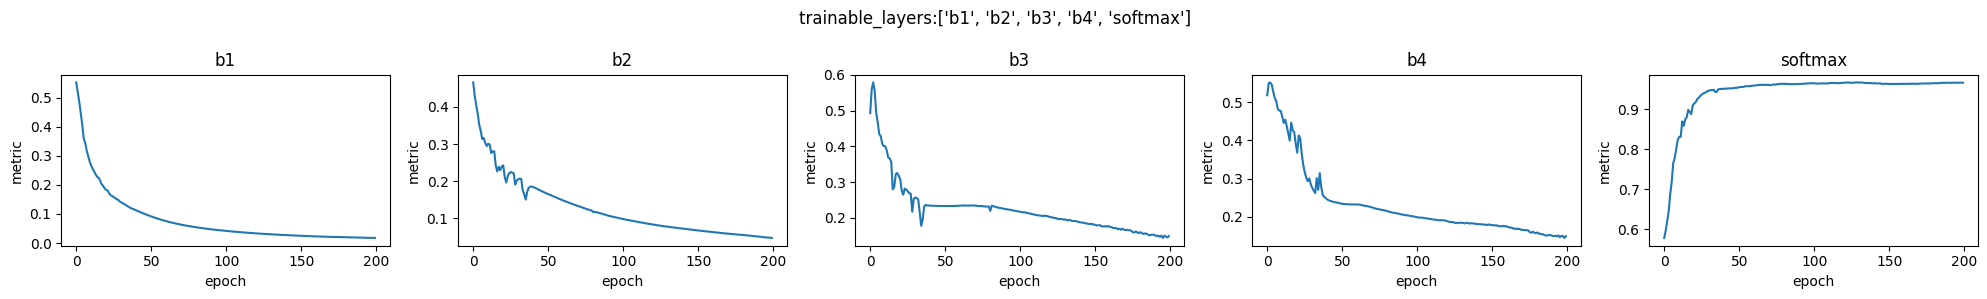

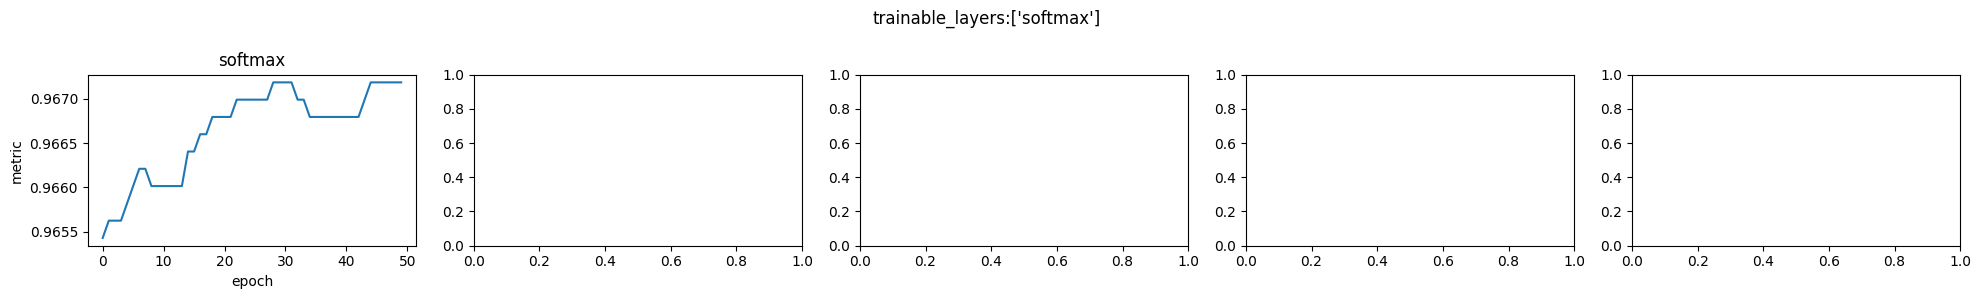

In [7]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = False,
    batch_size = 128,
    data_shuffle_seed = None, #Changed
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200],
        [['softmax'], 50], 
    ],
    show_metrics_max = ['softmax'],
)

## 6. change to training one layer at a time

200/200 [==============================] - 126s 628ms/step - softmax: 0.9438 - best_softmax: 0.9461


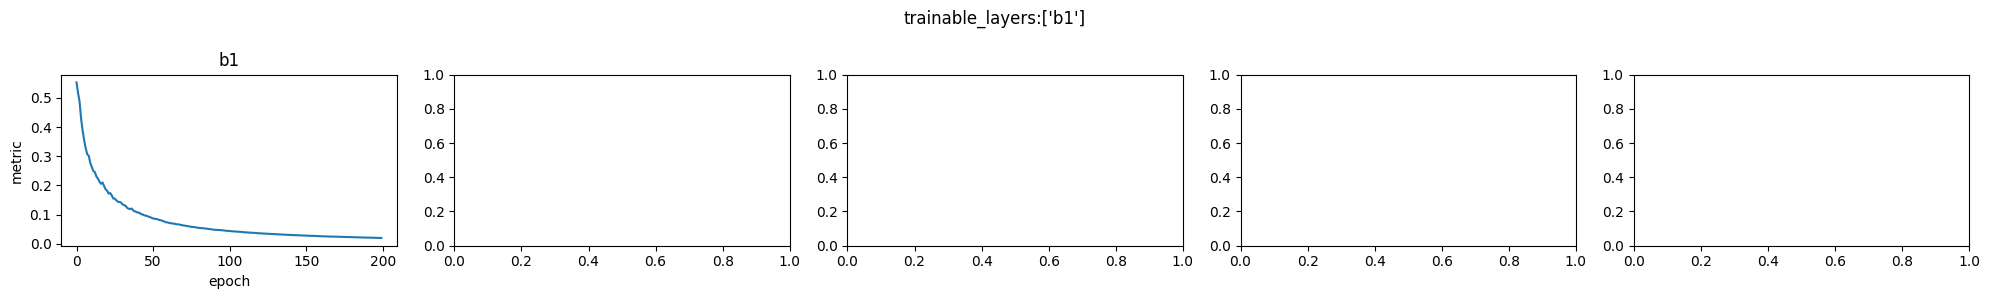

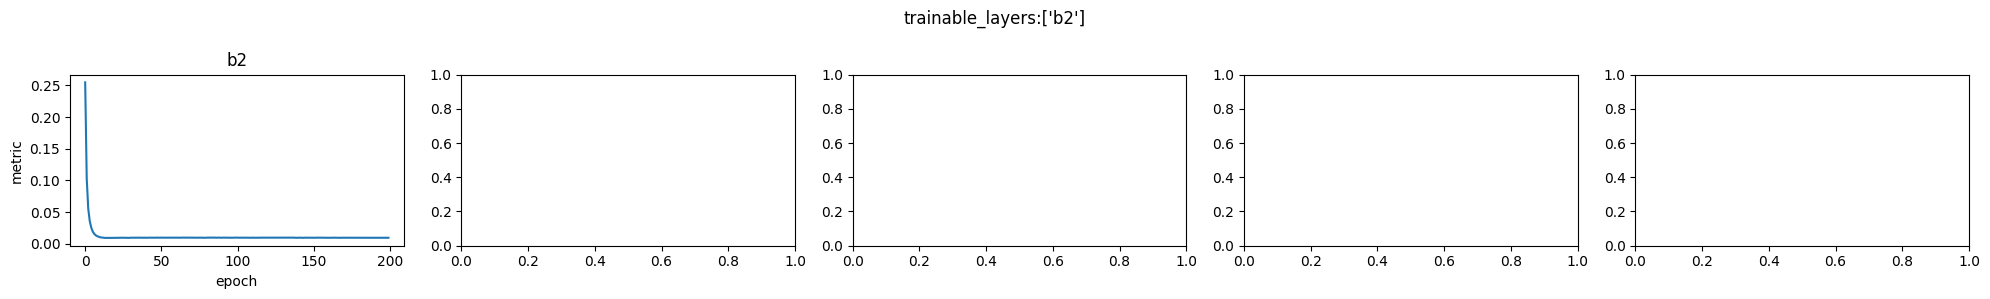

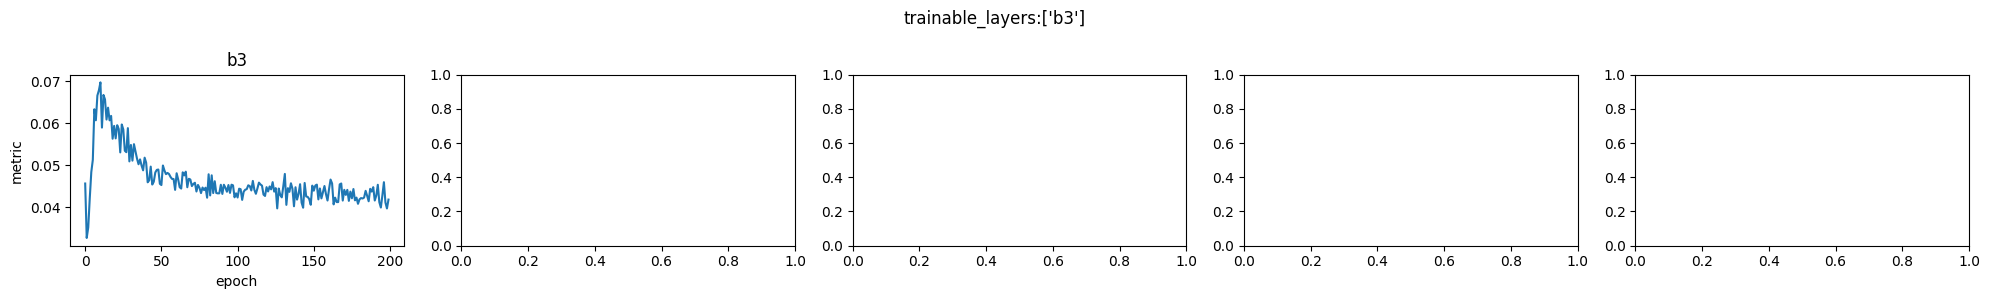

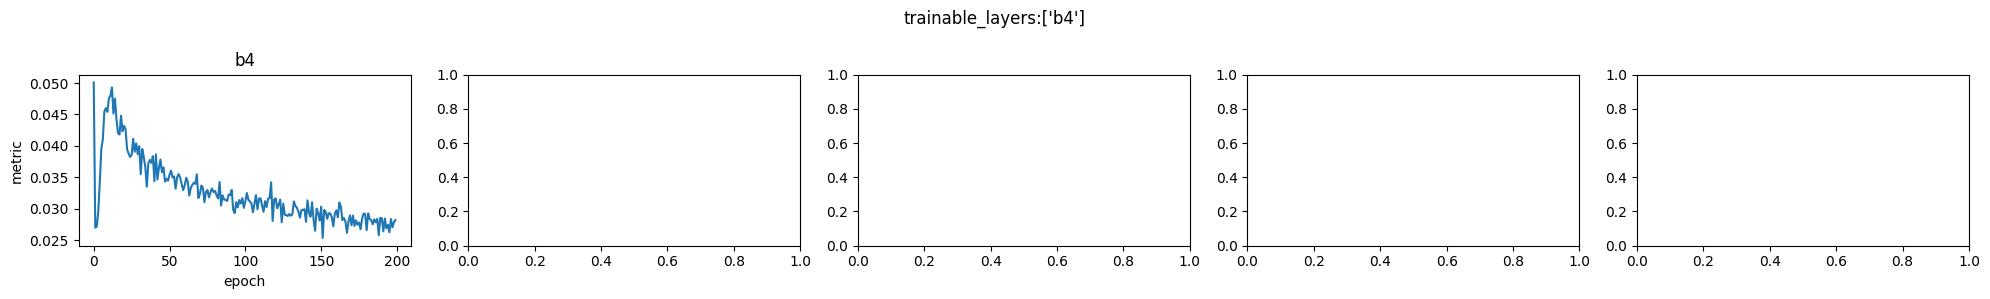

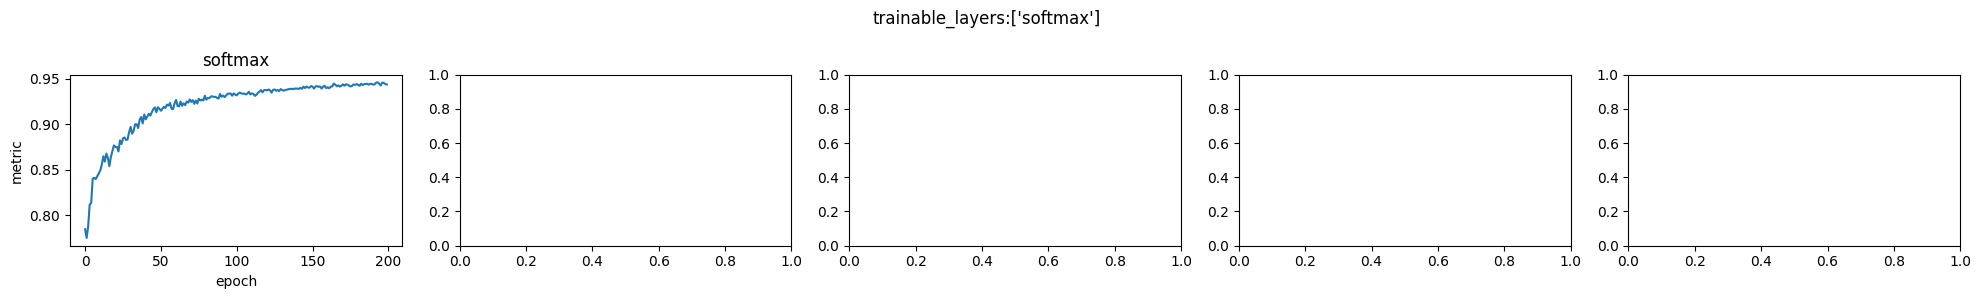

In [8]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = False,
    batch_size = 128,
    data_shuffle_seed = 10,
    trainable_layers_list = [ #Changed
        [['b1', ], 200], # 200 epochs of training layer b1
        [['b2', ], 200], # followed by 200 epochs of training layer b2
        [['b3', ], 200], # followed by 200 epochs of training layer b3
        [['b4', ], 200], # followed by 200 epochs of training layer b4
        [['softmax', ], 200], # followed by 200 epochs of training layer softmax
    ],
    show_metrics_max = ['softmax'],
)

# B. Supervised-wise FF tests 7 - 12

## 7. original setting

200/200 [==============================] - 506s 3s/step - b1: 0.0100 - b2: 0.0233 - b3: 0.0933 - b4: 0.1073 - goodness_duped: 0.7568 - best_goodness_duped: 0.7641


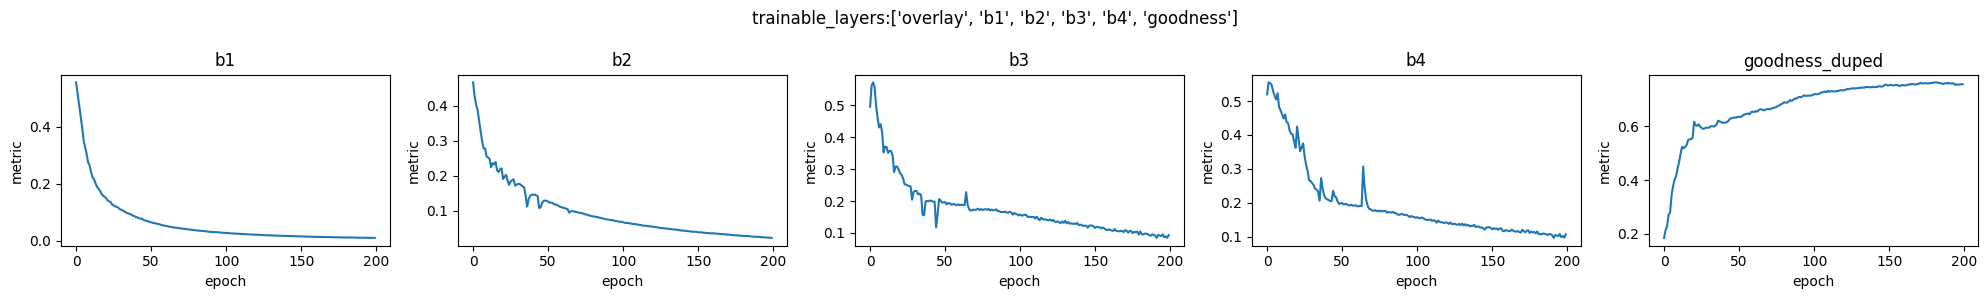

In [9]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = True,
    batch_size = 128,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

## 8. change `units = 500`

200/200 [==============================] - 2533s 13s/step - b1: 0.0066 - b2: 0.0042 - b3: 0.0121 - b4: 0.0331 - goodness_duped: 0.8393 - best_goodness_duped: 0.9256


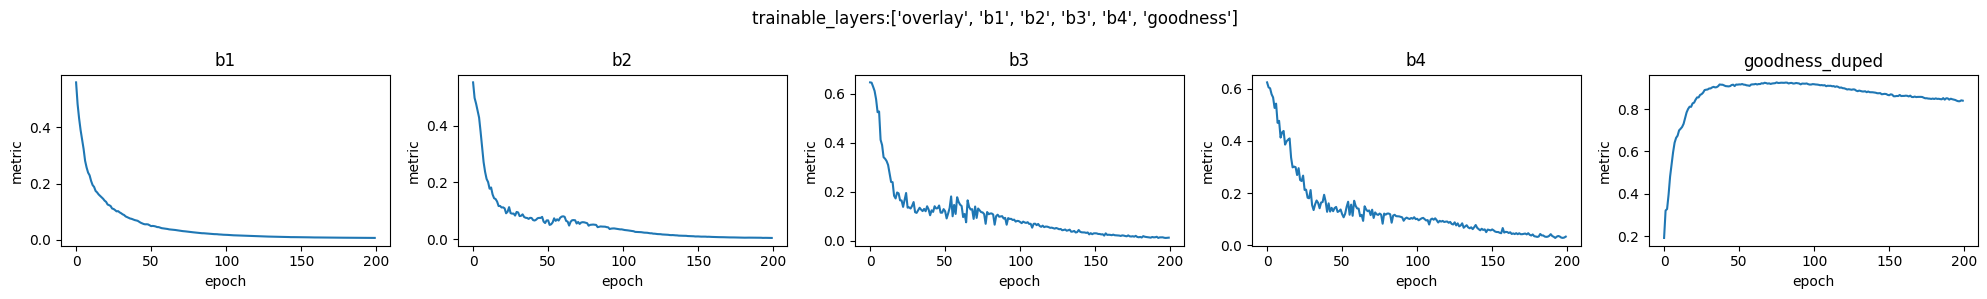

In [10]:
train_mgr = train_layers(
    units = 500, #Changed
    is_supervised_ff = True,
    batch_size = 128,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

## 9. change `batch_size = 512`

200/200 [==============================] - 453s 2s/step - b1: 0.0170 - b2: 0.0457 - b3: 0.1006 - b4: 0.1121 - goodness_duped: 0.8010 - best_goodness_duped: 0.8010


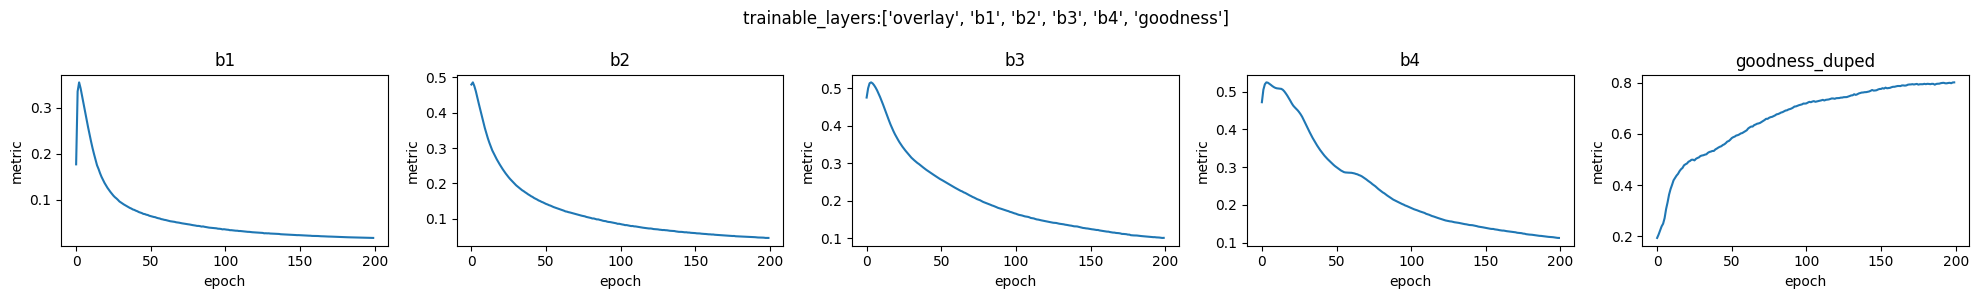

In [11]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = True,
    batch_size = 512, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

## 10. change `batch_size = 32`

200/200 [==============================] - 533s 3s/step - b1: 0.0094 - b2: 0.0213 - b3: 0.1052 - b4: 0.0965 - goodness_duped: 0.7582 - best_goodness_duped: 0.7771


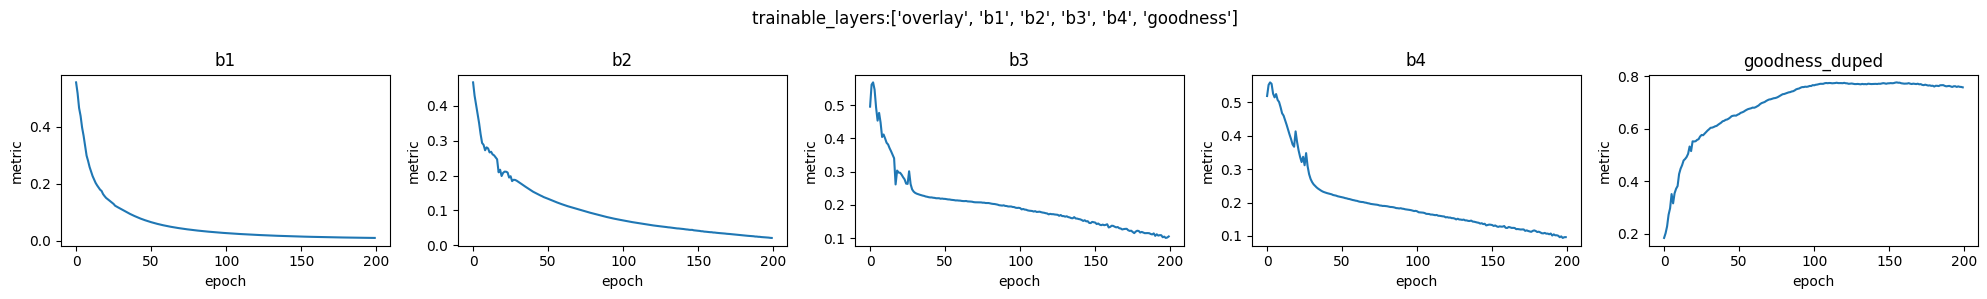

In [12]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = True,
    batch_size = 128,
    data_shuffle_seed = None, #Changed
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

## 11. disable data shuffling

200/200 [==============================] - 1103s 6s/step - b1: 0.0166 - b2: 0.0385 - b3: 0.0552 - b4: 0.1274 - goodness_duped: 0.7145 - best_goodness_duped: 0.7145


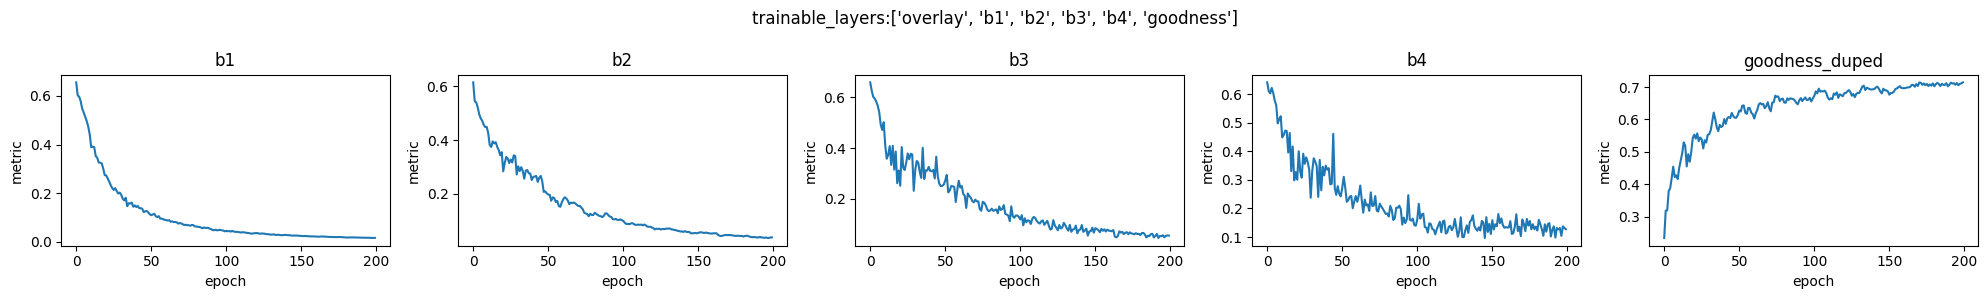

In [13]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = True,
    batch_size = 32, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

## 12. change to training one layer at a time

200/200 [==============================] - 366s 2s/step - b4: 0.0129 - goodness_duped: 0.5586 - best_goodness_duped: 0.5656


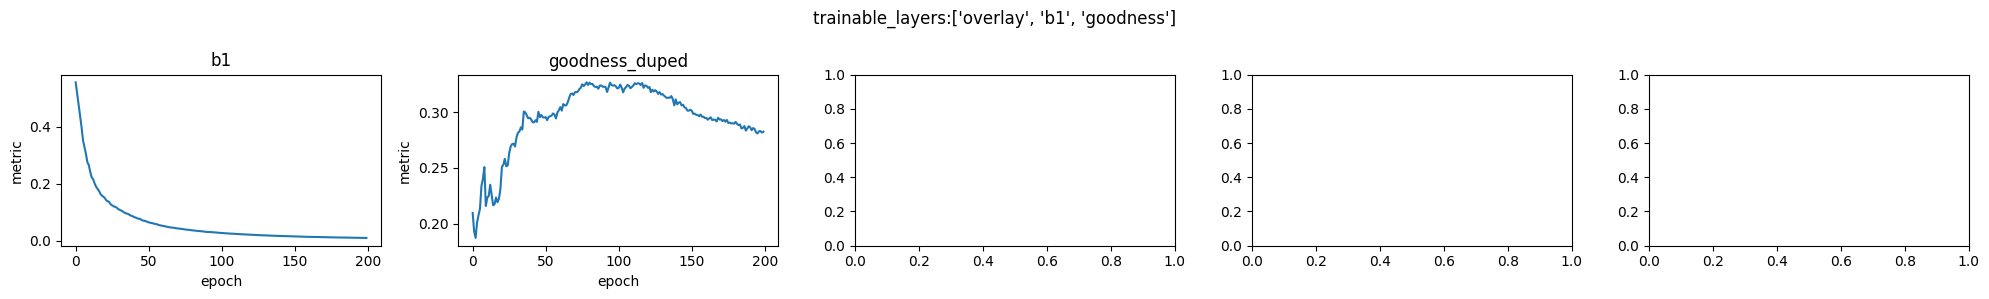

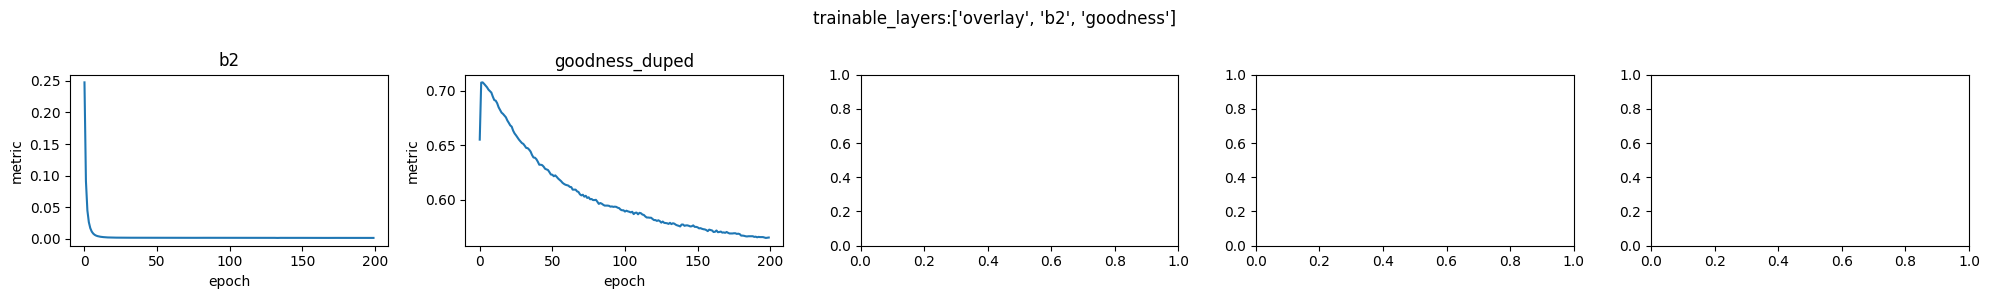

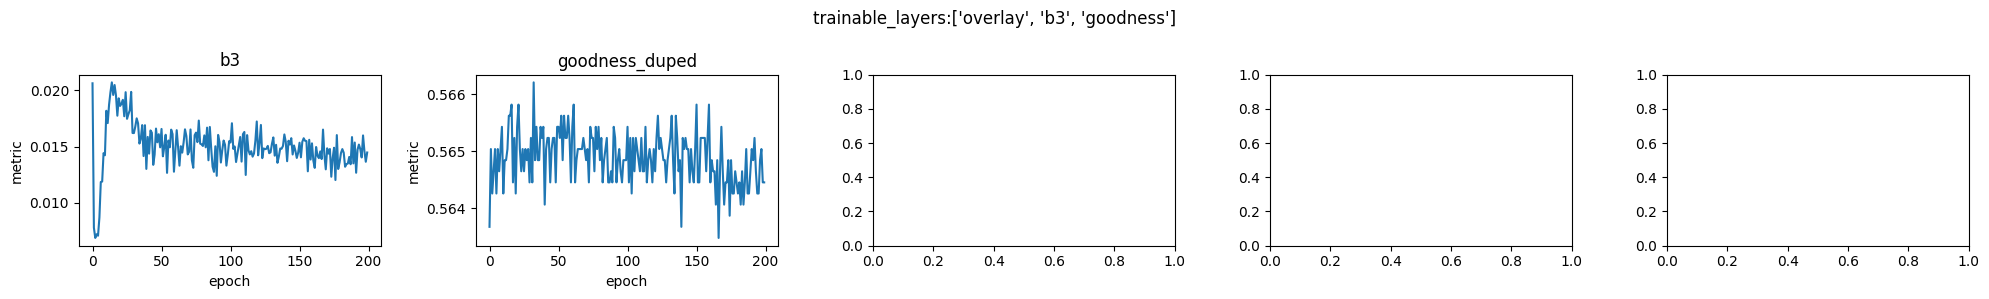

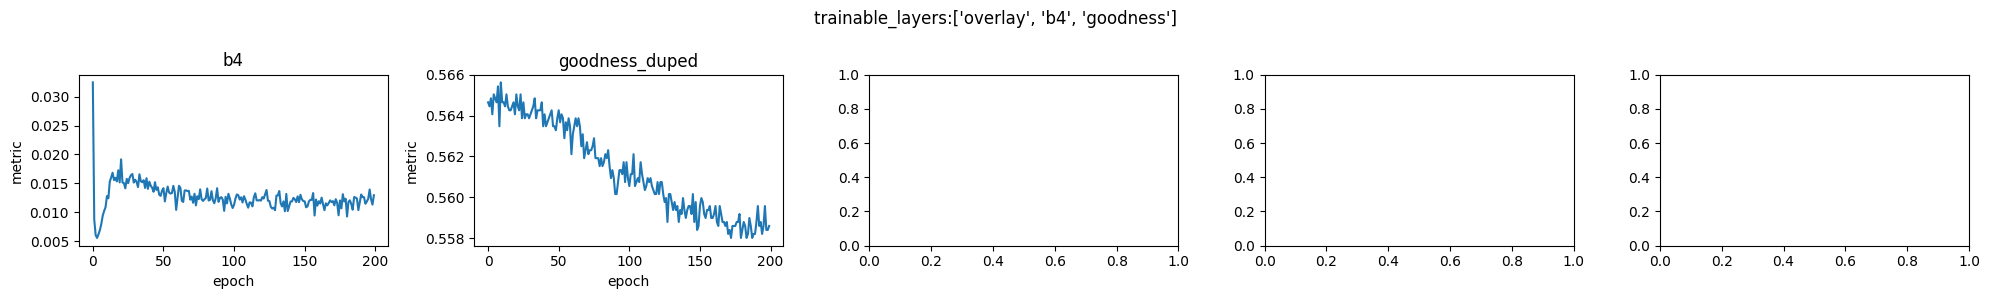

In [14]:
train_mgr = train_layers(
    units = 100,
    is_supervised_ff = True,
    batch_size = 128,
    data_shuffle_seed = 10,
    trainable_layers_list = [ #Changed
        [['overlay', 'b1', 'goodness', ], 200],
        [['overlay', 'b2', 'goodness', ], 200],
        [['overlay', 'b3', 'goodness', ], 200],
        [['overlay', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

# C. Combine best parameters

## 13. unsupervised-wise. Change to `units = 500` and `batch_size = 512`

50/50 [==============================] - 78s 2s/step - softmax: 0.9842 - best_softmax: 0.9844


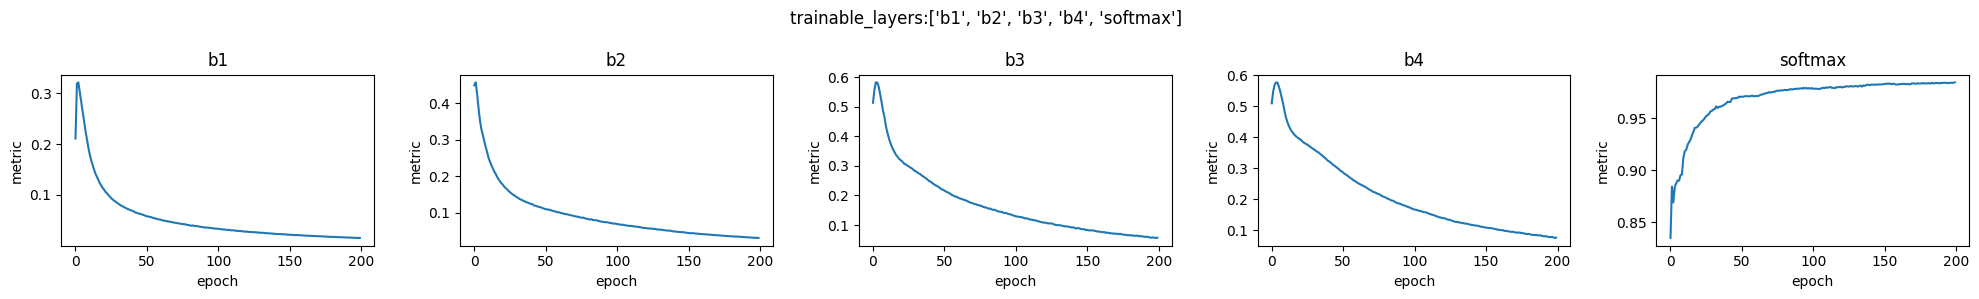

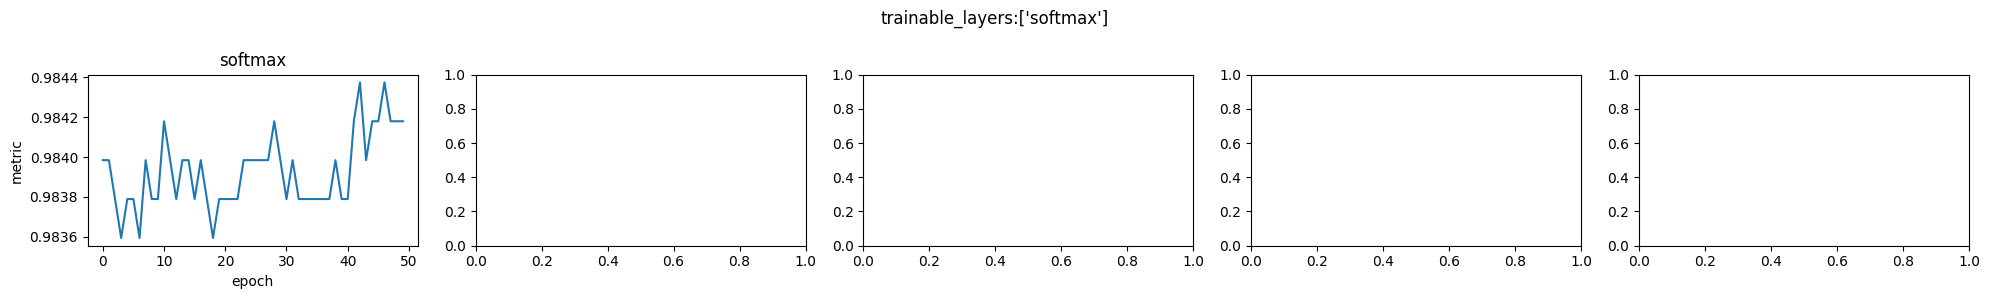

In [15]:
train_mgr = train_layers(
    units = 500, #Changed
    is_supervised_ff = False,
    batch_size = 512, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200],
        [['softmax'], 50], 
    ],
    show_metrics_max = ['softmax'],
)

## 14. supervised-wise. Change to `units = 500` and `batch_size = 512`

200/200 [==============================] - 1005s 5s/step - b1: 0.0096 - b2: 0.0204 - b3: 0.0428 - b4: 0.0550 - goodness_duped: 0.9529 - best_goodness_duped: 0.9576


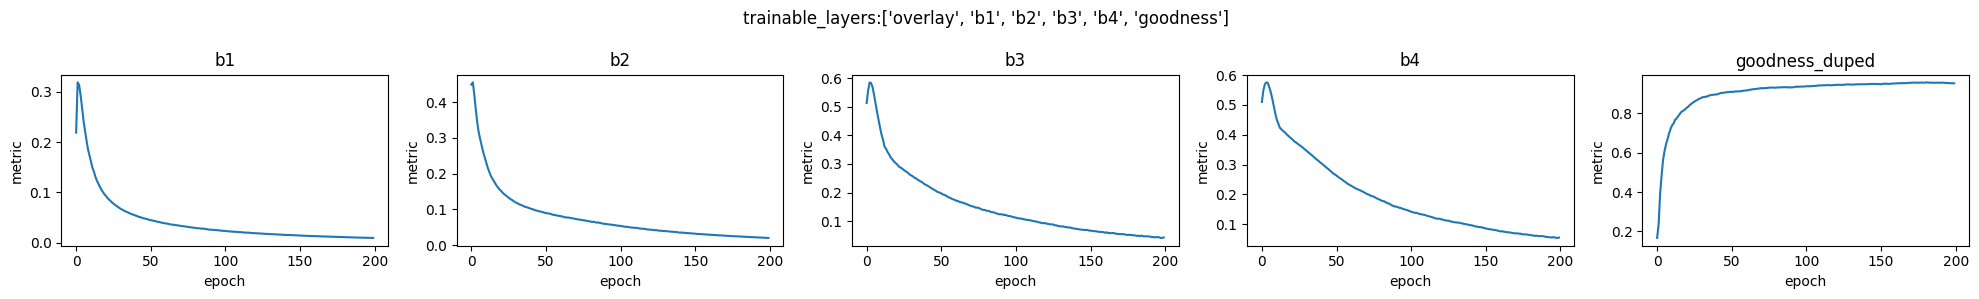

In [16]:
train_mgr = train_layers(
    units = 500, #Changed
    is_supervised_ff = True,
    batch_size = 512, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)

## D. Use the paper's 2000 units setting

## 15. unsupervised-wise. Change to `units = 2000` and `batch_size = 512`

50/50 [==============================] - 402s 8s/step - softmax: 0.9906 - best_softmax: 0.9910


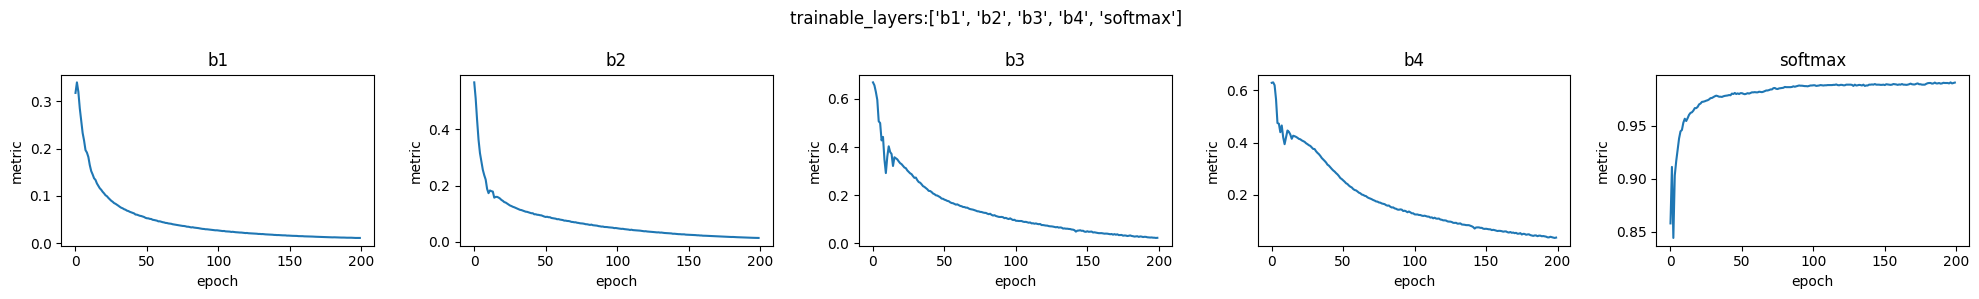

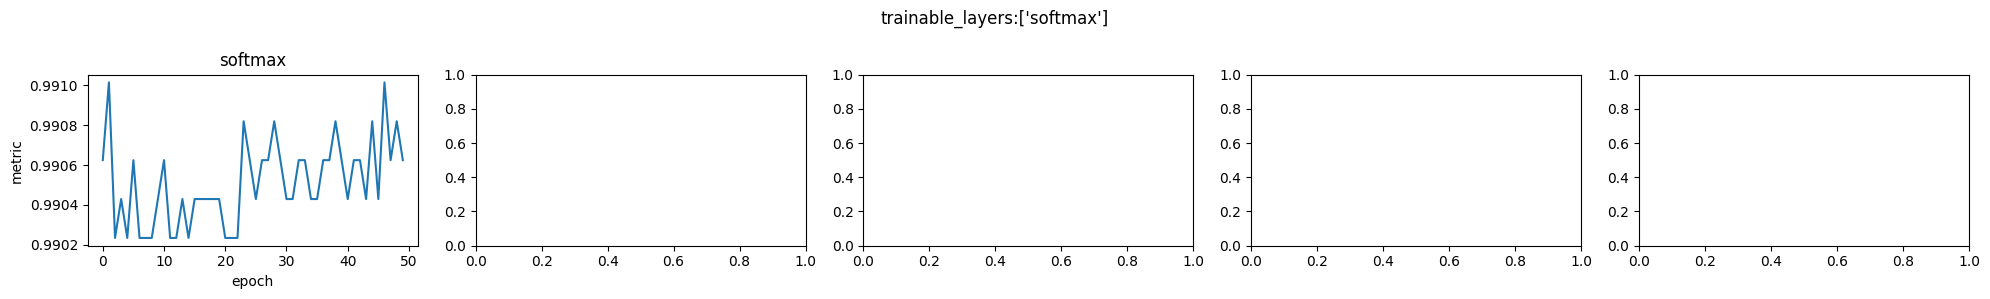

In [17]:
train_mgr = train_layers(
    units = 2000, #Changed
    is_supervised_ff = False,
    batch_size = 512, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['b1', 'b2', 'b3', 'b4', 'softmax'], 200],
        [['softmax'], 50], 
    ],
    show_metrics_max = ['softmax'],
)

## 16. supervised-wise. Change to `units = 2000` and `batch_size = 512`

200/200 [==============================] - 6785s 34s/step - b1: 0.0065 - b2: 0.0075 - b3: 0.0133 - b4: 0.0240 - goodness_duped: 0.9672 - best_goodness_duped: 0.9742


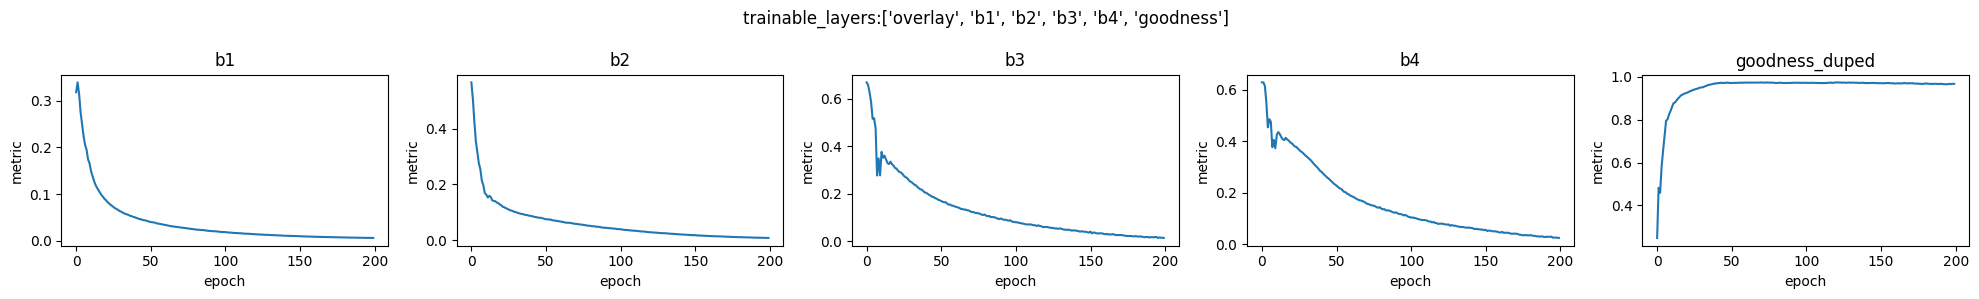

In [18]:
train_mgr = train_layers(
    units = 2000, #Changed
    is_supervised_ff = True,
    batch_size = 512, #Changed
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', ], 200],
    ],
    show_metrics_max = ['goodness'],
)